In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [28]:
def calculate_impacts(betas, cumulative_shifts, spend, saturation):
    # helpers
    num_channels = len(spend)
    num_days = len(spend[0])
    num_shifts = len(cumulative_shifts[0])
    
    range_channels = range(num_channels)
    range_days = range(num_days)
    extended_range_days = range(num_days + num_shifts - 1)

    # Initialize detailed matrices
    local_spend = [[0 for i in extended_range_days] for j in range_channels]
    detailed_impact = [[0 for i in extended_range_days] for j in range_channels]
    detailed_spend = [[0 for i in extended_range_days] for j in range_channels]
    saturated_impact = [[0 for i in extended_range_days] for j in range_channels]
    incremental_shifts = [[0 for i in range_days] for j in range_channels]

    # Calculate incremental first for the input is cumulative
    for c in range_channels:
        for d in range_days:
            if d == 0:
                incremental_shifts[c][d] = cumulative_shifts[c][0]
            else:
                incremental_shifts[c][d] = cumulative_shifts[c][d] - cumulative_shifts[c][d - 1]
    
    # Distribute spend base on time shifts
    for c in range_channels:
        for d in range_days:
            local_spend[c][d] = spend[c][d]
            for i in range(num_shifts):
                detailed_spend[c][d + i] += local_spend[c][d] * incremental_shifts[c][i]

    # Calculate impact from the detailed spend observing saturation
    for c in range_channels:
        for d in extended_range_days:
            local_saturation = np.interp(detailed_spend[c][d], saturation[0], saturation[c + 1])
            detailed_impact[c][d] = detailed_spend[c][d] * betas[c][d]
            if detailed_impact[c][d] > local_saturation:
                saturated_impact[c][d] = local_saturation
            else:
                saturated_impact[c][d] = detailed_impact[c][d]

    # Totals
    total_spend = 0
    total_impact = 0
    total_saturated_impact = 0
    for c in range_channels:
        for d in range_days:
            total_spend += spend[c][d]        
        for d in extended_range_days:
            total_impact += detailed_impact[c][d]
            total_saturated_impact += saturated_impact[c][d]

    # roi
    roi = total_saturated_impact / total_spend
    
    return {
        "cumulative_shifts": cumulative_shifts,
        "incremental_shifts": incremental_shifts,
        "total_spend": total_spend,
        "spend": local_spend,
        "detailed_spend": detailed_spend,
        "total_impact": total_impact,
        "total_saturated_impact": total_saturated_impact,
        "detailed_impact": detailed_impact,
        "saturated_impact": saturated_impact,
        "roi": roi
    }

In [29]:
# days
days = [0, 1, 2, 3, 4, 5, 6]

# Channels
channels = [
    "mailers",
    "influencers",
    "search"
]

channels_colors = [
    "red",
    "green",
    "blue"
]

# betas for a week
betas = [
        [1.8, 1.9, 1.8, 1.9, 1.8, 1.9, 1.8, 1.8, 1.9, 1.8, 1.9, 1.8, 1.9, 1.8],
        [4.3, 4.4, 4.0, 4.4, 4.0, 4.4, 4.0, 4.3, 4.4, 4.0, 4.4, 4.0, 4.4, 4.0],
        [1.4, 1.2, 1.0, 0.9, 1.0, 1.2, 1.0, 1.4, 1.2, 1.0, 0.9, 1.0, 1.2, 1.0]
        ]   

# percentage of cumulative impact
time_shifts = [
        [0.10, 0.15, 0.20, 0.30, 0.45, 0.80, 1.00],
        [0.30, 0.55, 0.70, 0.80, 0.85, 0.90, 1.00],
        [0.80, 0.90, 0.95, 0.99, 1.00, 1.00, 1.00]
        ]

saturation = [
        [0, 17.924406, 71.697626, 161.319658, 286.790504, 448.110162, 645.278634, 878.295918, 1147.162016, 1451.876926, 1792.44065, 2168.853186],
        [0, 141.308741, 548.75405, 1178.488876, 1972.462648, 2871.879947, 3826.015924, 4795.683883, 5753.048675, 6679.741193, 7564.57628, 8401.499691],
        [0, 98.371215, 392.848131, 881.533867, 1561.310734, 2427.903909, 3475.966752, 4699.184263, 6090.390621, 7641.696462, 9344.621472, 11190.228136],
        [0, 29.374948, 114.732808, 248.515354, 420.220227, 618.513547, 832.890164, 1054.600347, 1276.930335, 1495.072955, 1705.809656, 1907.150328]
        ]


In [30]:
viable_spend_0 = [
        [10, 20, 30, 40, 50, 60, 70],
        [20, 40, 60, 80, 100, 120, 140],
        [30, 60, 90, 120, 150, 180, 210]
]

viable_spend_1 = [
        [10, 10, 10, 10, 10, 10, 10],
        [20, 20, 20, 20, 20, 20, 20],
        [30, 30, 30, 30, 30, 30, 30]
]

results = calculate_impacts(betas, time_shifts, viable_spend_1, saturation)

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_shifts(results, channels, channels_colors):
    x = np.array(list(range(len(results["spend"][0]))))
    
    plt.figure()
    plt.title("Impact shifts")
    
    for i in range(len(channels)):
        plt.plot(x, results["cumulative_shifts"][i], color=channels_colors[i], alpha=0.2, label=channels[i])
        plt.plot(x, results["incremental_shifts"][i], color=channels_colors[i], label="incremental " + channels[i])
    
    plt.legend()
    plt.show()

In [23]:
def plot_saturation(saturation, channels, channels_colors):
    x = np.array(saturation[0])
    
    plt.figure()
    plt.title("Saturation")
    
    for i in range(len(channels)):
        plt.plot(x, saturation[i + 1], color=channels_colors[i], label=channels[i])
    
    plt.legend()
    plt.show()

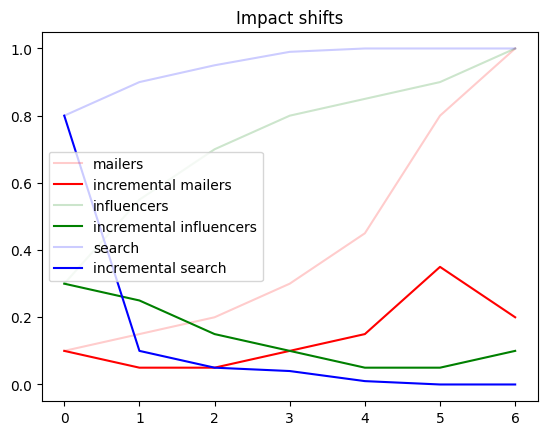

In [12]:
plot_shifts(results, channels, channels_colors)

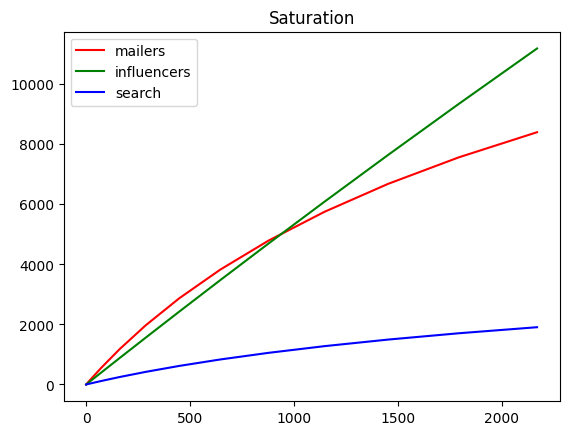

In [24]:
plot_saturation(saturation, channels, channels_colors)

In [59]:
def plot_spend(results, channels, channels_colors):
    x = np.array(list(range(len(results["detailed_spend"][0]))))
    
    plt.figure()
    
    total_spend = results["total_spend"]
    plt.title(f"Spend total = {total_spend}")
    for i in range(len(channels)):
        plt.plot(x, results["spend"][i], color=channels_colors[i], alpha=0.2, label=channels[i])
        plt.plot(x, results["detailed_spend"][i], color=channels_colors[i], label="shifted " + channels[i])
    
    plt.legend(fontsize="8")
    plt.show()

In [70]:
def plot_impacts(results, channels, channels_colors):
    x = np.array(list(range(len(results["detailed_spend"][0]))))

    plt.figure()
    
    total_impact = results["total_saturated_impact"]
    total_spend = results["total_spend"]
    roi = results["roi"]
    
    plt.title(f"Impact {total_impact:.2f} Spend {total_spend:.2f} ROI {roi:.2f}")
    for i in range(len(channels)):
        plt.plot(x, results["detailed_impact"][i], color=channels_colors[i], alpha=0.2, label=channels[i])
        plt.plot(x, results["saturated_impact"][i], color=channels_colors[i], label="saturated " + channels[i])
        plt.plot(x, results["detailed_spend"][i], color=channels_colors[i], alpha=0.2, label="spend " + channels[i], linestyle='dashed')

    plt.axvspan(7, 14, facecolor='gray', alpha=0.1)

    plt.legend(fontsize="8")
    plt.show()

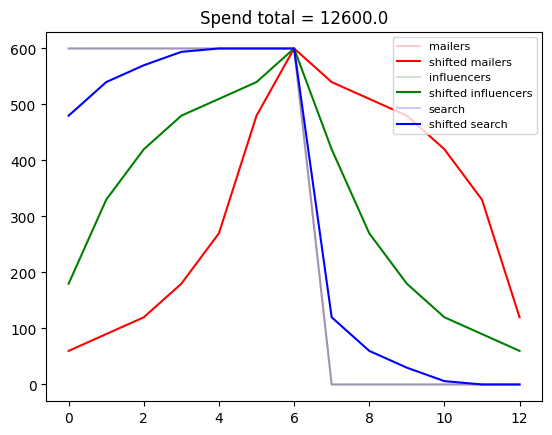

In [60]:
plot_spend(results, channels, channels_colors)

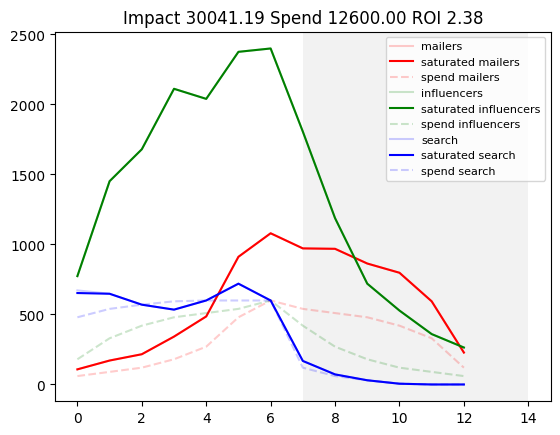

In [71]:
plot_impacts(results, channels, channels_colors)

In [45]:
value_per_channel = 4200

test_spends = array = [[[0 for _ in range(len(days))] for _ in range(len(channels))] for _ in range(len(days))]

for d in days:
    value_per_day = value_per_channel / (d + 1)
    for c in range(len(channels)):
        for i in range(d + 1):
            test_spends[d][c][i] = value_per_day
                    

In [46]:
test_results = []

for spend in test_spends:
    test_results.append(calculate_impacts(betas, time_shifts, spend, saturation))

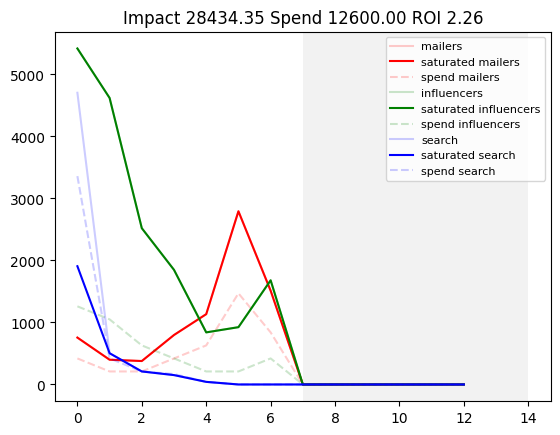

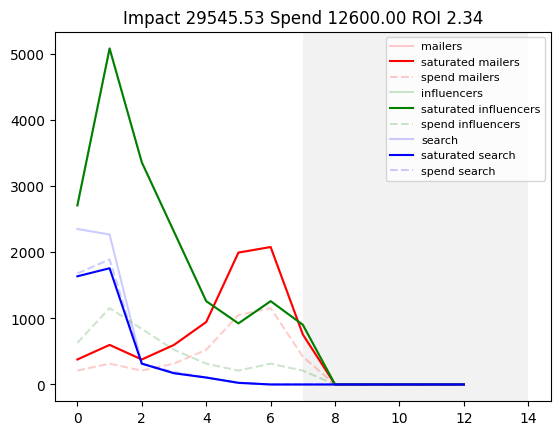

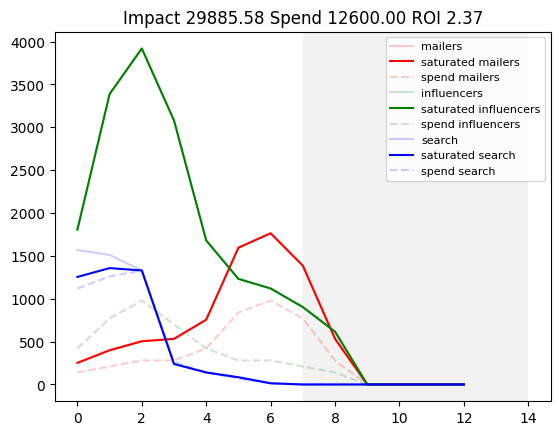

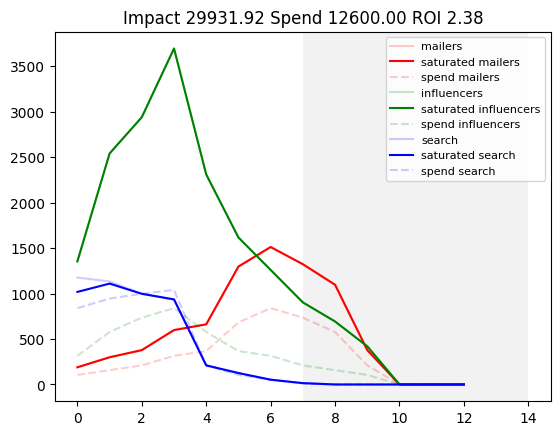

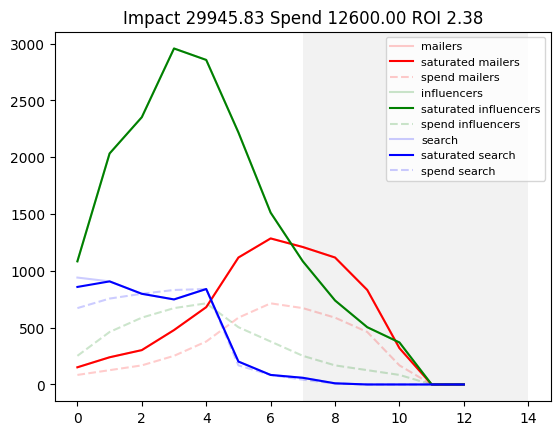

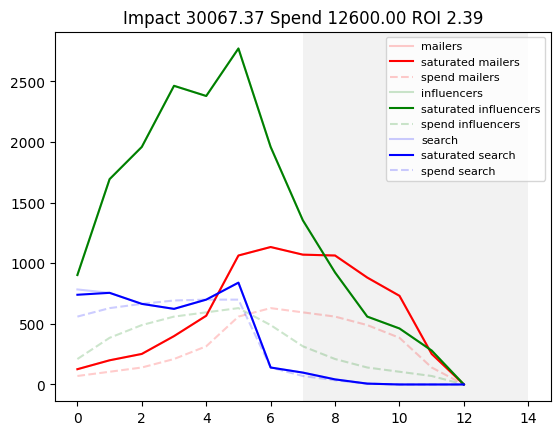

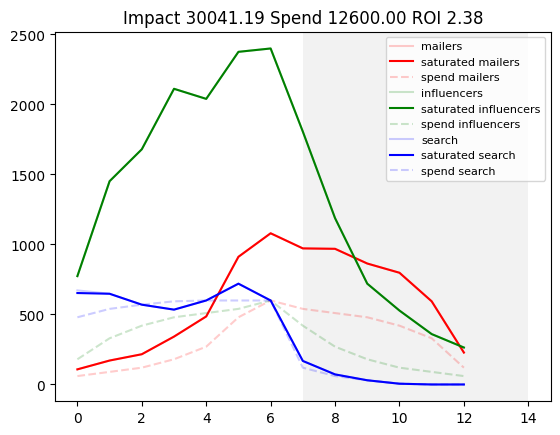

In [72]:
for results in test_results:
    plot_impacts(results, channels, channels_colors)


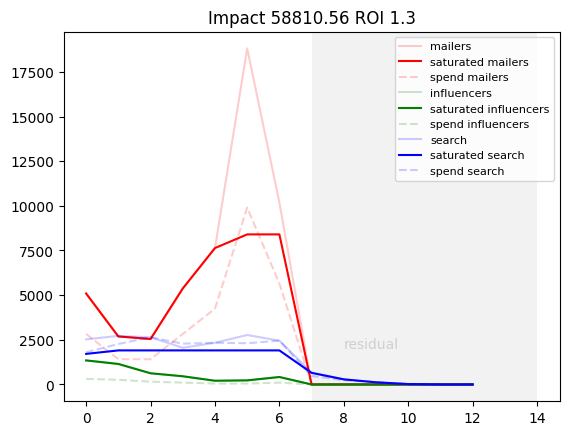

In [62]:
real_spend = [
    [28283,0,0,0,0,0,0],
    [1044,0,0,0,0,0,0],
    [2255,2552,2845,2227,2307,2283,2490]
]
plot_impacts(calculate_impacts(betas, time_shifts, real_spend, saturation), channels, channels_colors)